**Importing the Relevant Libraries**

https://github.com/polive106/Time-Series-Forecasting-DeepAR/blob/master/Energy_Consumption_Exercise.ipynb

https://kekayan.medium.com/forecasting-with-deepar-for-busy-people-ed67f9d9a00d

https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar_best_practices

https://www.youtube.com/watch?v=g8UYGh0tlK0&ab_channel=AmazonWebServices

https://www.youtube.com/watch?v=xcbj0RE3kfI

I referred to the attached links when performing this DeepAR analysis.

In [1]:
#! conda upgrade -y numpy
import pandas as pd
pd.set_option('display.max_columns',100)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import json

We set up the relevant libraries for sagemaker here.

In [7]:
!conda install -y s3fs 
! pip install -U sagemaker

Solving environment: done

# All requested packages already installed.



In [4]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

In [11]:
bucket="2022-04-06-air"
prefix="sagemaker/DEMO-deepar"

boto_session = boto3.session.Session(region_name="ap-southeast-1")
sagemaker_client = boto_session.client(service_name='sagemaker', region_name="ap-southeast-1")
sagemaker_session = sagemaker.session.Session(boto_session=boto_session, sagemaker_client=sagemaker_client)


s3_data_path = "{}/{}/data".format(bucket,prefix)
s3_output_path = "{}/{}/output".format(bucket,prefix)

**Loading the Data Set**

In [2]:
df = pd.read_table("LD2011_2014.txt", delimiter=";",low_memory=False)
df

,Unnamed: 0,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,MT_041,MT_042,MT_043,MT_044,MT_045,MT_046,MT_047,MT_048,MT_049,...,MT_321,MT_322,MT_323,MT_324,MT_325,MT_326,MT_327,MT_328,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,"56,7608861726509",0,"1003,78048780488","247,095070422535","177,559912854031","147,543640897756","264,11575562701","644,444444444444","135,514705882353","45,08125","129,62962962963",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
1,2011-01-01 00:30:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,"56,7608861726509",0,"967,195121951219","243,573943661972","177,559912854031","131,321695760598","264,11575562701","592,592592592593","129,632352941176","50,0875","119,212962962963",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
2,2011-01-01 00:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,"55,9969442322383",0,"991,585365853659","231,232394366197","180,82788671024","136,321695760598","283,440514469453","622,222222222222","125,205882352941","41,95625","127,314814814815",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
3,2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,"58,2887700534759",0,"991,585365853659","232,992957746479","181,917211328976","130,074812967581","293,086816720257","614,814814814815","125,205882352941","45,08125",125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
4,2011-01-01 01:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,"56,7608861726509",0,"967,195121951219","234,753521126761","177,559912854031","125,087281795511","276,977491961415","607,407407407407","141,397058823529","45,08125","122,685185185185",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140251,2014-12-31 23:00:00,"2,53807106598985","22,0483641536273","1,73761946133797","150,406504065041","85,3658536585366","303,571428571429","11,3058224985868","282,828282828283","68,1818181818182","72,0430107526882","71,5350223546945","168,085106382979","35,6550580431177","50,4148053605616","65,599173553719","84,8519362186788","82,659478885894","357,827476038339","13,0653266331658","63,4361233480176","193,717277486911","31,1332503113325","18,4696569920844","49,3827160493827","322,429906542056","38,9830508474576","48,1120584652862","140,519730510106","78,8979336255479","58,7803085966201","141,447368421053","30,2171860245515","64,2737896494157","29,3296089385475","181,434599156118","10,3270223752151","162,47582205029","120,418848167539","59,7232337946103","65,9340659340659","153,409090909091","63,5324015247776","1159,09090909091","73,4982332155477","76,1421319796954","227,488151658768","33,8983050847458","16,2218733647305","1304,34782608696",...,"50,

**Data Cleaning**

To perform data cleaning, we first rename the column "Unnamed:0" to "DateTime" and convert it to the datatime format in Python. We then convert the strings in the data set to floats for easier manipulation. Moreover, sinch the data is recorded in 15-minute intervals, we need to divide the data by four to convert it to kWh.

For the sake of simplicity, we first look at one column of our data set, namely "MT_001".

In [3]:
df.rename(
    columns=({ 'Unnamed: 0': 'DateTime'}), 
    inplace=True,
)
df['DateTime'] =  pd.to_datetime(df['DateTime'])
df

,DateTime,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,MT_041,MT_042,MT_043,MT_044,MT_045,MT_046,MT_047,MT_048,MT_049,...,MT_321,MT_322,MT_323,MT_324,MT_325,MT_326,MT_327,MT_328,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,"56,7608861726509",0,"1003,78048780488","247,095070422535","177,559912854031","147,543640897756","264,11575562701","644,444444444444","135,514705882353","45,08125","129,62962962963",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
1,2011-01-01 00:30:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,"56,7608861726509",0,"967,195121951219","243,573943661972","177,559912854031","131,321695760598","264,11575562701","592,592592592593","129,632352941176","50,0875","119,212962962963",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
2,2011-01-01 00:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,"55,9969442322383",0,"991,585365853659","231,232394366197","180,82788671024","136,321695760598","283,440514469453","622,222222222222","125,205882352941","41,95625","127,314814814815",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
3,2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,"58,2887700534759",0,"991,585365853659","232,992957746479","181,917211328976","130,074812967581","293,086816720257","614,814814814815","125,205882352941","45,08125",125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
4,2011-01-01 01:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,"56,7608861726509",0,"967,195121951219","234,753521126761","177,559912854031","125,087281795511","276,977491961415","607,407407407407","141,397058823529","45,08125","122,685185185185",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140251,2014-12-31 23:00:00,"2,53807106598985","22,0483641536273","1,73761946133797","150,406504065041","85,3658536585366","303,571428571429","11,3058224985868","282,828282828283","68,1818181818182","72,0430107526882","71,5350223546945","168,085106382979","35,6550580431177","50,4148053605616","65,599173553719","84,8519362186788","82,659478885894","357,827476038339","13,0653266331658","63,4361233480176","193,717277486911","31,1332503113325","18,4696569920844","49,3827160493827","322,429906542056","38,9830508474576","48,1120584652862","140,519730510106","78,8979336255479","58,7803085966201","141,447368421053","30,2171860245515","64,2737896494157","29,3296089385475","181,434599156118","10,3270223752151","162,47582205029","120,418848167539","59,7232337946103","65,9340659340659","153,409090909091","63,5324015247776","1159,09090909091","73,4982332155477","76,1421319796954","227,488151658768","33,8983050847458","16,2218733647305","1304,34782608696",...,"50,64

In [16]:
df.dtypes

DateTime    datetime64[ns]
MT_001              object
MT_002              object
MT_003              object
MT_004              object
                 ...      
MT_366              object
MT_367              object
MT_368              object
MT_369              object
MT_370              object
Length: 371, dtype: object

In [4]:
df["MT_001"] = [float(str(i).replace(",", "")) for i in df["MT_001"]]
df

,DateTime,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,MT_041,MT_042,MT_043,MT_044,MT_045,MT_046,MT_047,MT_048,MT_049,...,MT_321,MT_322,MT_323,MT_324,MT_325,MT_326,MT_327,MT_328,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,"56,7608861726509",0,"1003,78048780488","247,095070422535","177,559912854031","147,543640897756","264,11575562701","644,444444444444","135,514705882353","45,08125","129,62962962963",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
1,2011-01-01 00:30:00,0.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,"56,7608861726509",0,"967,195121951219","243,573943661972","177,559912854031","131,321695760598","264,11575562701","592,592592592593","129,632352941176","50,0875","119,212962962963",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
2,2011-01-01 00:45:00,0.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,"55,9969442322383",0,"991,585365853659","231,232394366197","180,82788671024","136,321695760598","283,440514469453","622,222222222222","125,205882352941","41,95625","127,314814814815",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
3,2011-01-01 01:00:00,0.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,"58,2887700534759",0,"991,585365853659","232,992957746479","181,917211328976","130,074812967581","293,086816720257","614,814814814815","125,205882352941","45,08125",125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
4,2011-01-01 01:15:00,0.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,"56,7608861726509",0,"967,195121951219","234,753521126761","177,559912854031","125,087281795511","276,977491961415","607,407407407407","141,397058823529","45,08125","122,685185185185",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140251,2014-12-31 23:00:00,2.538071e+14,"22,0483641536273","1,73761946133797","150,406504065041","85,3658536585366","303,571428571429","11,3058224985868","282,828282828283","68,1818181818182","72,0430107526882","71,5350223546945","168,085106382979","35,6550580431177","50,4148053605616","65,599173553719","84,8519362186788","82,659478885894","357,827476038339","13,0653266331658","63,4361233480176","193,717277486911","31,1332503113325","18,4696569920844","49,3827160493827","322,429906542056","38,9830508474576","48,1120584652862","140,519730510106","78,8979336255479","58,7803085966201","141,447368421053","30,2171860245515","64,2737896494157","29,3296089385475","181,434599156118","10,3270223752151","162,47582205029","120,418848167539","59,7232337946103","65,9340659340659","153,409090909091","63,5324015247776","1159,09090909091","73,4982332155477","76,1421319796954","227,488151658768","33,8983050847458"

In [5]:
df["MT_001"] = (df["MT_001"]/4).astype(int)
df

,DateTime,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,MT_041,MT_042,MT_043,MT_044,MT_045,MT_046,MT_047,MT_048,MT_049,...,MT_321,MT_322,MT_323,MT_324,MT_325,MT_326,MT_327,MT_328,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,"56,7608861726509",0,"1003,78048780488","247,095070422535","177,559912854031","147,543640897756","264,11575562701","644,444444444444","135,514705882353","45,08125","129,62962962963",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
1,2011-01-01 00:30:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,"56,7608861726509",0,"967,195121951219","243,573943661972","177,559912854031","131,321695760598","264,11575562701","592,592592592593","129,632352941176","50,0875","119,212962962963",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
2,2011-01-01 00:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,"55,9969442322383",0,"991,585365853659","231,232394366197","180,82788671024","136,321695760598","283,440514469453","622,222222222222","125,205882352941","41,95625","127,314814814815",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
3,2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,"58,2887700534759",0,"991,585365853659","232,992957746479","181,917211328976","130,074812967581","293,086816720257","614,814814814815","125,205882352941","45,08125",125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
4,2011-01-01 01:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,"56,7608861726509",0,"967,195121951219","234,753521126761","177,559912854031","125,087281795511","276,977491961415","607,407407407407","141,397058823529","45,08125","122,685185185185",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140251,2014-12-31 23:00:00,63451776649746,"22,0483641536273","1,73761946133797","150,406504065041","85,3658536585366","303,571428571429","11,3058224985868","282,828282828283","68,1818181818182","72,0430107526882","71,5350223546945","168,085106382979","35,6550580431177","50,4148053605616","65,599173553719","84,8519362186788","82,659478885894","357,827476038339","13,0653266331658","63,4361233480176","193,717277486911","31,1332503113325","18,4696569920844","49,3827160493827","322,429906542056","38,9830508474576","48,1120584652862","140,519730510106","78,8979336255479","58,7803085966201","141,447368421053","30,2171860245515","64,2737896494157","29,3296089385475","181,434599156118","10,3270223752151","162,47582205029","120,418848167539","59,7232337946103","65,9340659340659","153,409090909091","63,5324015247776","1159,09090909091","73,4982332155477","76,1421319796954","227,488151658768","33,8983050847458","16,2218733647305","1304,34782608696",...,"50,649350

In [6]:
df_mt1 = df[['DateTime', 'MT_001']].set_index('DateTime').astype("int64")
df_mt1

,MT_001
DateTime,
2011-01-01 00:15:00,0
2011-01-01 00:30:00,0
2011-01-01 00:45:00,0
2011-01-01 01:00:00,0
2011-01-01 01:15:00,0
...,...
2014-12-31 23:00:00,63451776649746
2014-12-31 23:15:00,63451776649746
2014-12-31 23:30:00,63451776649746


Now we have a univariate time series showing the usage of electricity for "MT_001". This will be useful for our modelling using DeepAR later.

In [20]:
print('Number of missing values per column')
df_mt1.isnull().sum()

Number of missing values per column


MT_001    0
dtype: int64

In [21]:
df_mt1.dtypes

MT_001    int64
dtype: object

We have checked that there is no missing value in our univariate time series, and the data type is int64.

**DeepAR Modelling**

Our goal is to forecast the use of electricity for one month beyond the data we currently have, namely the use of electricity in Jan 2015. To do that, we need to create training and test sets and fit the models. But first, let us load the relevant libraries required for our modelling process.

In [7]:
!pip install mxnet gluonts ujson
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean

from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

<Figure size 864x432 with 0 Axes>

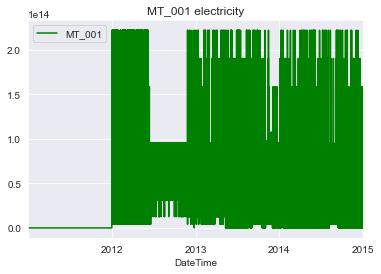

In [8]:
plt.figure(figsize=(12,6))
df_mt1.plot(title='MT_001 electricity', color='green')
plt.show()

Plotting our electricity data on a graph, we realise that the data becomes available starting from the year 2012. There seems to be a rather drastic dip towards the end of 2012 and a slight drop in 2014. Other than that, the data seems to fluctuate quite a bit.

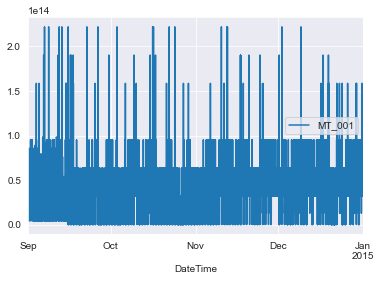

In [20]:
df_mt1["2014-09-01":"2015-01-01"].plot();

In [9]:
!pip install --upgrade protobuf
!pip install --user statsmodels -U
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas

In [25]:
max(df_mt1['MT_001'])

222081218274111

In [27]:
np.mean(df_mt1['MT_001'])

33858570778065.938

In our training data, we look at electricity usage in the three most recent months.

In [10]:
train_time = "2014-09-01 00:00:15"
prediction_length = 2880

In [11]:
estimator = DeepAREstimator(
    freq="15min",
    prediction_length=prediction_length,
    context_length=8640,
    num_layers = 2,
    num_cells = 40,
    cell_type = "lstm",
    trainer = Trainer(epochs=4))

In [12]:
training_data = ListDataset(
    [{"start": df_mt1.index[0], "target": df_mt1.MT_001[:train_time]}],
    freq = "15min"
)

In [13]:
predictor = estimator.train(training_data = training_data)

100%|██████████| 50/50 [45:41<00:00, 54.83s/it, epoch=4/4, avg_epoch_loss=31.2]


In [14]:
test_data = ListDataset(
    [
        {"start": df_mt1.index[0], "target": df_mt1.MT_001[:"2014-10-01 00:15:00"]},
        {"start": df_mt1.index[0], "target": df_mt1.MT_001[:"2014-11-01 00:15:00"]}
    ],
    freq = "15min"
)

**Visualisation of Results**

To visualise the results of our forecasts, we plot our predictions of electricity usage against time.

In [15]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = prediction_length
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

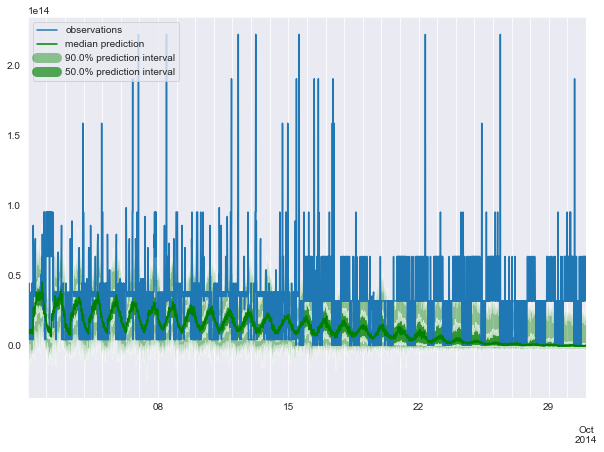

In [16]:
plot_prob_forecasts(ts_entry, forecast_entry)

**Evaluation and Conclusion**

In [17]:
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 2/2 [00:00<00:00, 12.31it/s]


{
    "MSE": 9.205022757178199e+26,
    "abs_error": 1.3278103566968422e+17,
    "abs_target_sum": 2.050513937975214e+17,
    "abs_target_mean": 35599200312069.69,
    "seasonal_error": 15773728837515.531,
    "MASE": 1.4623875666725397,
    "MAPE": 0.7277010874226976,
    "sMAPE": 0.9802448908487955,
    "MSIS": 13.206844667071424,
    "QuantileLoss[0.1]": 4.229009866840499e+16,
    "Coverage[0.1]": 0.10746527777777778,
    "QuantileLoss[0.2]": 7.587636885469158e+16,
    "Coverage[0.2]": 0.17517361111111113,
    "QuantileLoss[0.3]": 1.014071625604072e+17,
    "Coverage[0.3]": 0.20451388888888888,
    "QuantileLoss[0.4]": 1.2031079906414413e+17,
    "Coverage[0.4]": 0.2361111111111111,
    "QuantileLoss[0.5]": 1.327810334786601e+17,
    "Coverage[0.5]": 0.2815972222222222,
    "QuantileLoss[0.6]": 1.40215811028258e+17,
    "Coverage[0.6]": 0.3618055555555556,
    "QuantileLoss[0.7]": 1.4102273989756845e+17,
    "Coverage[0.7]": 0.4588541666666667,
    "QuantileLoss[0.8]": 1.31733509129